# Public Health Expenditures, Economic Outcomes and Health Outcomes


This project explores the relationship between public health expenditures, health outcomes, and economic performance using data from the WHO Global Health Observatory, IMF, and World Bank.

## Intro


In this project, we expore the relationship between public health expenditures and health outcomes using a comprehensive dataset that included various parameters such as GDP per capita, life expectancy, unemployment rate, population growth, neonatal mortality rate, health expenditure as a percentage of GDP, and health expenditure per capita. Our goal is to understand how health investments impact the overall health and economic performance of countries worldwide.

## Libraries and Setup

### Import necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

In [ ]:
COUNTRIES = [
    "United States", "Canada", "Germany", "United Kingdom", "France", "Japan", "Australia",
    "Switzerland", "Netherlands", "Sweden", "Norway", "Denmark", "Finland", "Singapore",
    "South Korea", "New Zealand", "Austria", "Belgium", "Ireland", "Iceland",
    "China", "India", "Brazil", "Russia", "Mexico", "South Africa", "Turkey", "Indonesia",
    "Argentina", "Poland", "Thailand", "Malaysia", "Saudi Arabia", "Chile", "Greece",
    "Portugal", "Hungary", "Czech Republic", "Israel", "United Arab Emirates",
    "Nigeria", "Pakistan", "Bangladesh", "Ethiopia", "Philippines", "Vietnam", "Kenya",
    "Tanzania", "Uganda", "Ghana", "Yemen", "Afghanistan", "Sudan", "Haiti", "Nepal",
    "Mozambique", "Madagascar", "Democratic Republic of the Congo", "Zambia", "Mali",
    "Albania", "Armenia", "Azerbaijan", "Belarus", "Bosnia and Herzegovina", "Bulgaria",
    "Croatia", "Cyprus", "Estonia", "Georgia", "Italy", "Kazakhstan", "Latvia",
    "Lithuania", "Luxembourg", "Malta", "Moldova", "Montenegro", "North Macedonia",
    "Romania", "Serbia", "Slovakia", "Slovenia", "Spain", "Ukraine", "Uzbekistan",
    "Egypt", "Colombia", "Venezuela", "Peru", "Algeria", "Morocco", "Jordan", "Tunisia",
    "Iraq", "Syria", "Lebanon", "Libya", "Mongolia", "Kyrgyzstan", "Sri Lanka", "Myanmar",
    "Cambodia", "Laos", "Papua New Guinea", "Fiji", "Solomon Islands", "Botswana", "Namibia",
    "Zimbabwe", "Rwanda", "Burundi", "Malawi", "Lesotho", "Eswatini (Swaziland)",
    "Central African Republic", "Chad", "Somalia", "Sierra Leone", "Liberia"
]


### Settings for better visualization

In [ ]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)

## Data Collection

We import and read all the datasets we decided to work with.

### WHO Global Health Observatory Data

In [ ]:
health_expenditure_as_percentage_from_gdp_set = pd.read_csv('/datasets/health_expenditure_as_percentage_from_gdp.csv')
health_expenditure_per_capita_set = pd.read_csv('/datasets/health_expenditure_per_capita.csv')

### World Bank Data

In [ ]:
gdp_per_capita_set = pd.read_csv('/datasets/gdp_per_capita.csv', delimiter=";")
gdp_per_capita_growth_set = pd.read_csv('/datasets/gdp_per_capita_growth.csv', delimiter=";")
life_expectancy_set = pd.read_csv('/datasets/life_expectancy.csv', delimiter=";")
unemployment_rate_set = pd.read_csv('/datasets/unemployment_rate.csv', delimiter=";")
population_growth_set = pd.read_csv('/datasets/population_growth.csv', delimiter=";")
mortality_rate_neonatal_set = pd.read_csv('/datasets/mortality_rate_neonatal.csv', delimiter=";")

## Data Processing

We begin by transforming and cleaning the datasets, ensuring that each dataset was properly formatted and filled missing values using linear regression or interpolation, backward or front fills. This allowes us to have a consistent and complete dataset for analysis, covering a wide range of countries and years.

### Cleaning and Standardizing Data


Original data was by country, and column values were the years. We formatted the data so it shows Country Name, Country Code, Year and Value. Where Value is the tables main value (ex. GDP_PER_CAPITA). We sort the table by Country Name first and by Year second. After which we use interpolation to fill the NaN values.


For the second function where we only have data from 2001-2023. We use Linear Regression to create and fill the years from 1960-2023 as we have these years in the other datasets.


Using the functions below we are able to do this for all sets.

In [ ]:
def _transform_data(df, value_name, countries):
    if countries:
        df = df[df['Country Name'].isin(countries)]

    year_columns = [col for col in df.columns if col.isdigit()]

    df_new = pd.melt(df, id_vars=['Country Name', 'Country Code'],
                      value_vars=year_columns, var_name='Year', value_name=value_name)

    df_new = df_new[['Country Name', 'Country Code', 'Year', value_name]]

    df_new['Year'] = df_new['Year'].astype(int)

    df_sorted = df_new.sort_values(by=['Country Name', 'Year'])

    df = df_sorted.copy()
    df[value_name] = df.groupby('Country Name')[value_name].ffill().bfill().interpolate()

    return df

In [ ]:
def _process_and_fill_data_with_regression(df, value_variable, countries):
    df.rename(columns={'Location': 'Country Name', 'SpatialDimValueCode': 'Country Code',
                       'Period': 'Year', 'Value': value_variable}, inplace=True)

    df = df[['Country Name', 'Country Code', 'Year', value_variable]]

    df['Country Name'] = df['Country Name'].replace('United States of America', 'United States')

    if countries:
      df = df[df['Country Name'].isin(countries)]

    df['Year'] = df['Year'].astype(int)

    df_sorted = df.sort_values(by=['Country Name', 'Year'])

    full_years = pd.DataFrame({'Year': range(1960, 2024)})

    df_filled = pd.DataFrame()

    for country in df['Country Name'].unique():
        country_data = df[df['Country Name'] == country].copy()
        country_data = pd.merge(full_years, country_data, on='Year', how='left')
        country_data['Country Name'] = country
        country_data['Country Code'] = country_data['Country Code'].ffill().bfill()

        known_data = country_data.dropna(subset=[value_variable])

        if len(known_data) > 1:
            X_known = known_data['Year'].values.reshape(-1, 1)
            y_known = known_data[value_variable].values

            model = LinearRegression()
            model.fit(X_known, y_known)

            missing_years = country_data[country_data[value_variable].isna()]['Year'].values.reshape(-1, 1)
            y_missing_pred = model.predict(missing_years)
            y_missing_pred = np.clip(y_missing_pred, 0, None)

            country_data.loc[country_data[value_variable].isna(), value_variable] = y_missing_pred

        df_filled = pd.concat([df_filled, country_data])

    df_filled = df_filled.sort_values(by=['Country Name', 'Year']).reset_index(drop=True)

    return df_filled


In [ ]:
df_gdp_per_capita = _transform_data(gdp_per_capita_set, 'GDP_PER_CAPITA', COUNTRIES)
df_gdp_per_capita_growth = _transform_data(gdp_per_capita_growth_set, 'GDP_PER_CAPITA_GROWTH_PERC', COUNTRIES)
df_life_expectancy = _transform_data(life_expectancy_set, 'LIFE_EXPECTANCY_YEARS', COUNTRIES)
df_unemployment_rate = _transform_data(unemployment_rate_set, 'UNEMPLOYMENT_RATE_PERC', COUNTRIES)
df_population_growth = _transform_data(population_growth_set, 'POPULATION_GROWTH', COUNTRIES)
df_mortality_rate_neonatal = _transform_data(mortality_rate_neonatal_set, 'MORTALITY_RATE_NEONATAL_PER_1000_LIVE_BABIES', COUNTRIES)
df_health_expenditure_as_percentage_from_gdp = _process_and_fill_data_with_regression(health_expenditure_as_percentage_from_gdp_set, 'HEALTH_EXPENDITURE_FROM_GDP_PERC', COUNTRIES)
df_health_expenditure_per_capita = _process_and_fill_data_with_regression(health_expenditure_per_capita_set, 'HEALTH_EXPENDITURE_PER_CAPITA', COUNTRIES)

df_gdp_per_capita.head()

<ipython-input-39-0803d17c22d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country Name'] = df['Country Name'].replace('United States of America', 'United States')
<ipython-input-39-0803d17c22d7>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Country Name'] = df['Country Name'].replace('United States of America', 'United States')


,Country Name,Country Code,Year,GDP_PER_CAPITA
0,Afghanistan,AFG,1960,62.369375
106,Afghanistan,AFG,1961,62.443703
212,Afghanistan,AFG,1962,60.950364
318,Afghanistan,AFG,1963,82.021738
424,Afghanistan,AFG,1964,85.511073


### Merging Dataframes

In [ ]:
def _merge_dataframes_on_key(dataframes, keys):
    merged_df = dataframes[0]
    for df in dataframes[1:]:
        merged_df = pd.merge(merged_df, df, on=keys, how='inner')
    return merged_df

keys = ['Country Name', 'Country Code', 'Year']
dataframes = [
    df_gdp_per_capita,
    df_gdp_per_capita_growth,
    df_life_expectancy,
    df_unemployment_rate,
    df_population_growth,
    df_mortality_rate_neonatal,
    df_health_expenditure_as_percentage_from_gdp,
    df_health_expenditure_per_capita
]

df = _merge_dataframes_on_key(dataframes, keys)
df

,Country Name,Country Code,Year,GDP_PER_CAPITA,GDP_PER_CAPITA_GROWTH_PERC,LIFE_EXPECTANCY_YEARS,UNEMPLOYMENT_RATE_PERC,POPULATION_GROWTH,MORTALITY_RATE_NEONATAL_PER_1000_LIVE_BABIES,HEALTH_EXPENDITURE_FROM_GDP_PERC,HEALTH_EXPENDITURE_PER_CAPITA
0,Afghanistan,AFG,1960,62.369375,0.927029,32.535,7.942,1.925952,79.0,0.000000,0.000000
1,Afghanistan,AFG,1961,62.443703,0.927029,33.068,7.942,1.925952,79.0,0.000000,0.000000
2,Afghanistan,AFG,1962,60.950364,0.927029,33.547,7.942,2.014879,79.0,0.000000,0.000000
3,Afghanistan,AFG,1963,82.021738,0.927029,34.016,7.942,2.078997,79.0,0.000000,0.000000
4,Afghanistan,AFG,1964,85.511073,0.927029,34.494,7.942,2.139651,79.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
6459,Zimbabwe,ZWE,2019,1421.868596,-8.177320,61.292,7.370,1.989253,26.1,3.230000,54.810000
6460,Zimbabwe,ZWE,2020,1372.696674,-9.670405,61.124,8.651,2.031112,25.5,2.950000,50.680000
6461,Zimbabwe,ZWE,2021,1773.920411,6.271613,59.253,9.540,2.045715,25.0,2.790000,62.740000
6462,Zimbabwe,ZWE,2022,1676.821489,4.387997,59.253,9.256,2.024036,25.0,2.346970,67.935909


In [ ]:
len(df['Country Name'].unique())

101

In [ ]:
df['Country Name'].unique()

array(['Afghanistan', 'Albania', 'Algeria', 'Argentina', 'Armenia',
       'Australia', 'Austria', 'Azerbaijan', 'Bangladesh', 'Belarus',
       'Belgium', 'Bosnia and Herzegovina', 'Botswana', 'Brazil',
       'Bulgaria', 'Burundi', 'Cambodia', 'Canada',
       'Central African Republic', 'Chad', 'Chile', 'China', 'Colombia',
       'Croatia', 'Cyprus', 'Denmark', 'Estonia', 'Ethiopia', 'Fiji',
       'Finland', 'France', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Haiti', 'Hungary', 'Iceland', 'India', 'Indonesia', 'Iraq',
       'Ireland', 'Israel', 'Italy', 'Japan', 'Jordan', 'Kazakhstan',
       'Kenya', 'Latvia', 'Lebanon', 'Lesotho', 'Liberia', 'Libya',
       'Lithuania', 'Luxembourg', 'Madagascar', 'Malawi', 'Malaysia',
       'Mali', 'Malta', 'Mexico', 'Mongolia', 'Montenegro', 'Morocco',
       'Mozambique', 'Myanmar', 'Namibia', 'Nepal', 'New Zealand',
       'Nigeria', 'North Macedonia', 'Norway', 'Pakistan',
       'Papua New Guinea', 'Peru', 'Philippines', 'Poland',

## Statistical Analysis

### Correlation Analysis

We conduct a correlation analysis for each country to identify how different parameters are related. This helps us understand the strength and direction of relationships between variables such as health expenditure per capita and life expectancy years. The correlation matrices provide insights into which countries have strong positive or negative correlations between health investments and health outcomes and economic performances.

In [ ]:
def _compute_correlation(df):
    parameter_columns = [
        'GDP_PER_CAPITA',
        'GDP_PER_CAPITA_GROWTH_PERC',
        'LIFE_EXPECTANCY_YEARS',
        'UNEMPLOYMENT_RATE_PERC',
        'POPULATION_GROWTH',
        'MORTALITY_RATE_NEONATAL_PER_1000_LIVE_BABIES',
        'HEALTH_EXPENDITURE_FROM_GDP_PERC',
        'HEALTH_EXPENDITURE_PER_CAPITA'
      ]
    correlation_dict = {}
    for country in df['Country Name'].unique():
        country_data = df[df['Country Name'] == country]
        country_data = country_data.set_index('Year')
        correlation_matrix = country_data[parameter_columns].corr()
        correlation_dict[country] = correlation_matrix
    return correlation_dict

In [ ]:
correlation_matrices = _compute_correlation(df)

### Regression Analysis

Building on the correlation analysis, we perform regression analysis to further investigate the relationships. We focus on understanding how changes in health expenditures influence life expectancy across different countries. This analysis provides us with coefficients that quantified the impact of health investments on health outcomes and economic performance.

The function below redicts any target variable with predictor variables. In the example below, we show how good the model is at predicting life expectancy in countries, if we have data about their health expenditures, GDP statistics and population.

In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def _perform_regression_analysis(df, target_variable, predictor_variables):
    regression_results = {}
    for country in df['Country Name'].unique():
        country_data = df[df['Country Name'] == country].dropna(subset=[target_variable] + predictor_variables)
        if len(country_data) > len(predictor_variables):
            X = country_data[predictor_variables]
            y = country_data[target_variable]

            model = LinearRegression()
            model.fit(X, y)
            y_pred = model.predict(X)
            r2 = r2_score(y, y_pred)
            coefficients = model.coef_
            intercept = model.intercept_

            regression_results[country] = {
                'coefficients': coefficients,
                'intercept': intercept,
                'r2': r2
            }
        else:
            regression_results[country] = {
                'coefficients': None,
                'intercept': None,
                'r2': None
            }
    return regression_results

In [ ]:
predictor_variables = [
    'GDP_PER_CAPITA',
    'GDP_PER_CAPITA_GROWTH_PERC',
    'POPULATION_GROWTH',
    'HEALTH_EXPENDITURE_FROM_GDP_PERC',
    'HEALTH_EXPENDITURE_PER_CAPITA'
]

target_variable = 'LIFE_EXPECTANCY_YEARS'

regression_results = _perform_regression_analysis(df, target_variable, predictor_variables)

example_countries = ['United States', 'North Macedonia']
for example_country in example_countries:
    print(f"Regression results for {example_country}:")
    print(f"Coefficients: {regression_results[example_country]['coefficients']}")
    print(f"Intercept: {regression_results[example_country]['intercept']}")
    print(f"R-squared: {regression_results[example_country]['r2']}")
    print()

Regression results for United States:
Coefficients: [-2.48643518e-05  3.99208831e-02  1.12629515e+00  1.22899666e+00
 -3.20622670e-04]
Intercept: 61.2014937632928
R-squared: 0.9368977868773631

Regression results for North Macedonia:
Coefficients: [-2.38375749e-03 -2.77006161e-01  5.94269599e-01 -3.79185364e+00
  2.02587584e-02]
Intercept: 107.12947282863391
R-squared: 0.8458321066411527



## Visualization

To visualize the findings, we create scatter plots and line plots. The scatter plots illustrate the relationship between health expenditure per capita and health outcomes for each country, as well as economic performances. By normalizing the values, we make it easier to compare trends across different scales. Additionally, we plott the trends over the years to observe how health expenditures and life expectancy evolved, as well as economic performances, highlighting the correlation between these two parameters.

### Example correlation for 'United States' and 'Macedonia'

We can see in the heat maps below that there is a high correlation between Health Expenditures and Health Outcomes. The higher the health expenditures, the better the health outcomes are. Similarly there is a high correlation between the Health Expenditures vs Economic Performance.

In [ ]:
def plot_correlation_heatmap(correlation_matrix, country_name):
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Matrix for {country_name}')
    plt.show()

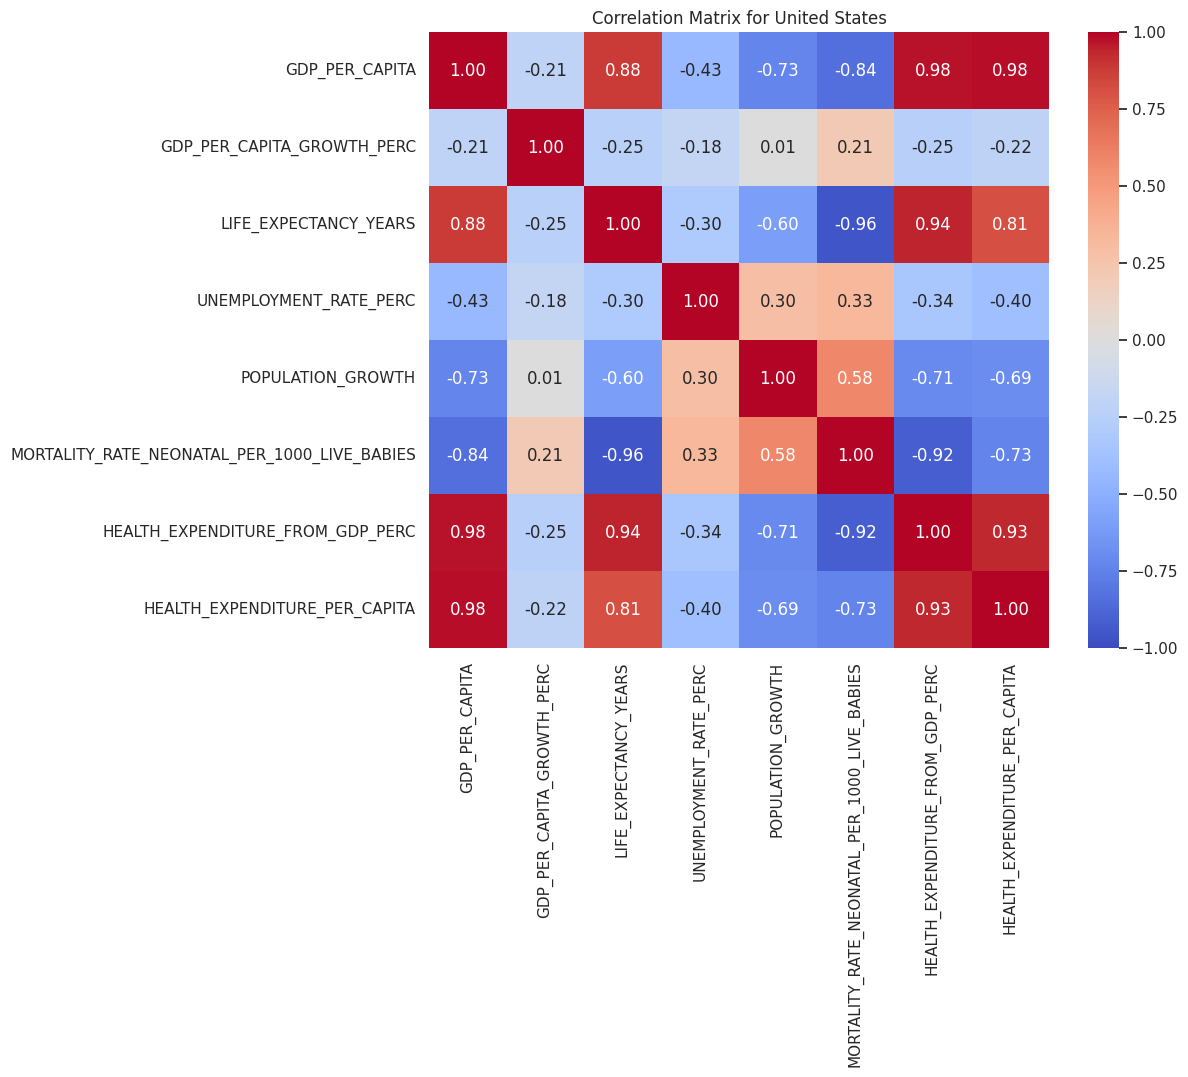

In [ ]:
plot_correlation_heatmap(correlation_matrices['United States'], 'United States')

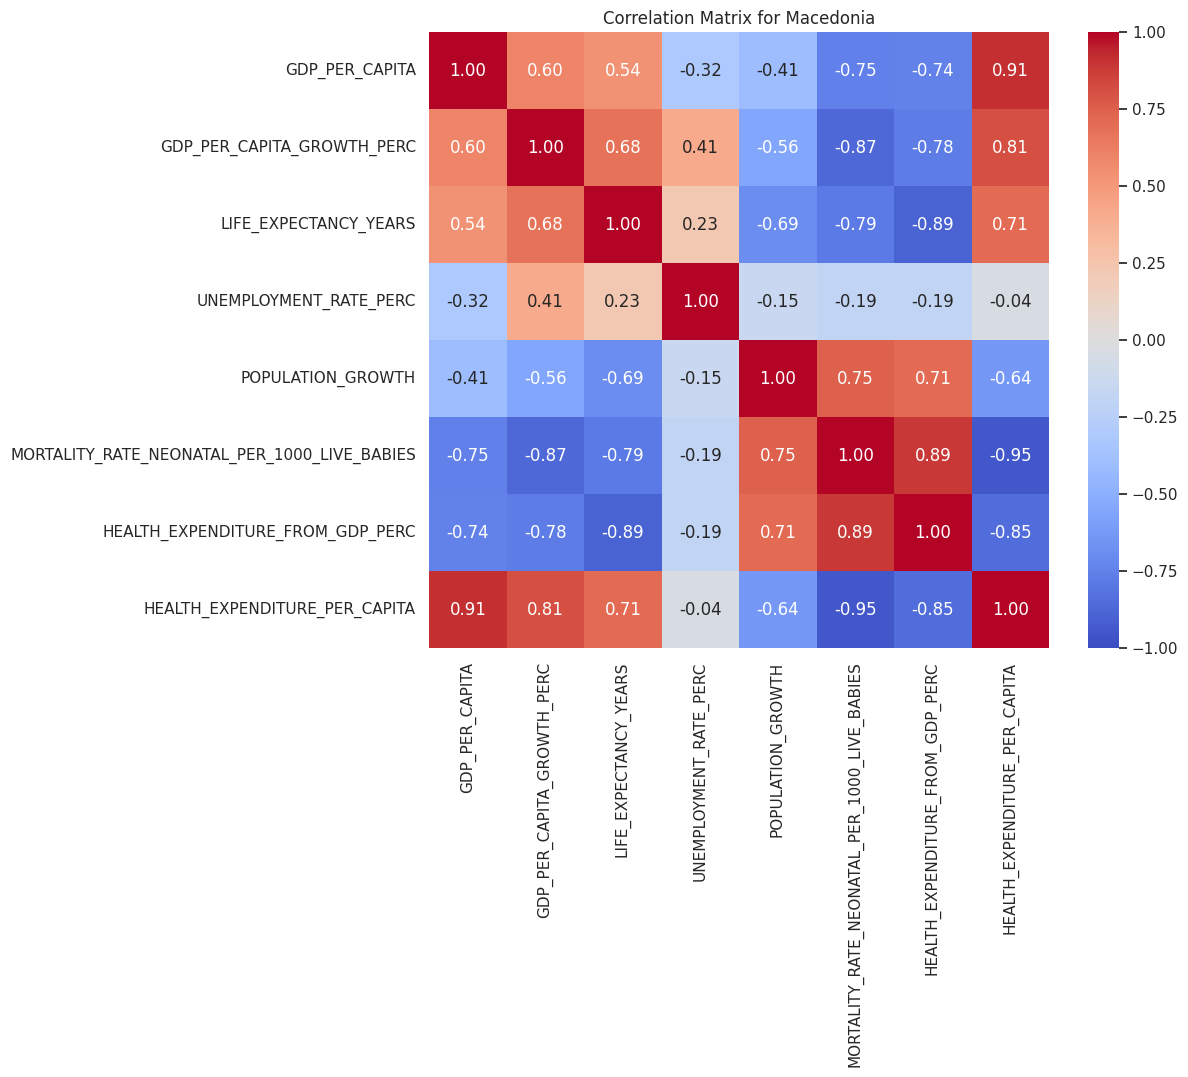

In [ ]:
plot_correlation_heatmap(correlation_matrices['North Macedonia'], 'Macedonia')

### Health Expenditures vs Health Outcomes


On the first graph we are showing health expenditures correlate with the life expectancy health outcomes for each country. We can notice that poorer countries or countries that spend less in health expenditures have worse health outcomes. These are countries like Nigeria, Uganda, Ethiopia,.. Similarly countries that spend more in health expenditures have better health outcomes. These are countries like the United States, Sweden, Denmark, Switzerland, Luxembourg, Poland, Slovenia. Similarly countries with middle-class incomes, have spent health expenditures somewhere between high and low class income countries, therefore their health outcomes are also "mid". These are countries like Macedonia, Ukraine, China, Mexico,.. It is important to notice that there is a "threshold", a point where having higher health expenditures does not increase life expectancy. For example the United States have the most health expenditures but they have the same life expectancy as countries like Singapore, Malta,.. Which makes sense because there are other factors affecting life expectancy and it would be "too good to be true" if spending much more on health expenditure would increase life expectancy to something impossible.

On the second graph we are showing a graph where we can see the Health Expenditure per Capita and the Life Expectancy globally for all countries averaged over the years from 1960-2023. We can see that on average globally over the years as the health expenditures increase the life expectancy increases. Ofcourse there are other factors to take into consideration for life expectancy, but this shows a strong correlation between the health expenditures and life expectancy. The values were normalized to address the issue of different scales between health expenditures and life expectancy.

In [ ]:
def _plot_average_health_expenditure_vs_outcome(df, expenditure_col, outcome_col):
    df[expenditure_col] = pd.to_numeric(df[expenditure_col], errors='coerce')
    df[outcome_col] = pd.to_numeric(df[outcome_col], errors='coerce')

    df_avg = df.groupby('Country Name')[[expenditure_col, outcome_col]].mean().reset_index()

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=expenditure_col, y=outcome_col, data=df_avg, hue='Country Name', palette='tab20')
    plt.title('Average Health Expenditure per Capita vs Average Life Expectancy Years')
    plt.xlabel('Health Expenditure per Capita')
    plt.ylabel('Life Expectancy (Years)')
    plt.legend(title='Country Name', bbox_to_anchor=(1.05, 1), loc='upper left')

    texts = []
    for i, row in df_avg.iterrows():
        texts.append(plt.text(row[expenditure_col], row[outcome_col], row['Country Name'], fontsize=9))

    plt.show()

In [ ]:
def _plot_normalized_expenditure_vs_life_expectancy_over_years(df, expenditure_col, outcome_col):
    df[expenditure_col] = pd.to_numeric(df[expenditure_col], errors='coerce')
    df[outcome_col] = pd.to_numeric(df[outcome_col], errors='coerce')

    df_avg = df.groupby('Year')[[expenditure_col, outcome_col]].mean().reset_index()

    scaler = MinMaxScaler()
    df_avg[[expenditure_col, outcome_col]] = scaler.fit_transform(df_avg[[expenditure_col, outcome_col]])

    plt.figure(figsize=(14, 10))
    sns.lineplot(x='Year', y=expenditure_col, data=df_avg, label=expenditure_col)
    sns.lineplot(x='Year', y=outcome_col, data=df_avg, label=outcome_col)

    plt.title('Normalized Health Expenditure per Capita and Life Expectancy Over the Years')
    plt.xlabel('Year')
    plt.yticks([])
    plt.ylabel('Normalized Values')
    plt.legend(title='Parameter')
    plt.grid(True)
    plt.show()

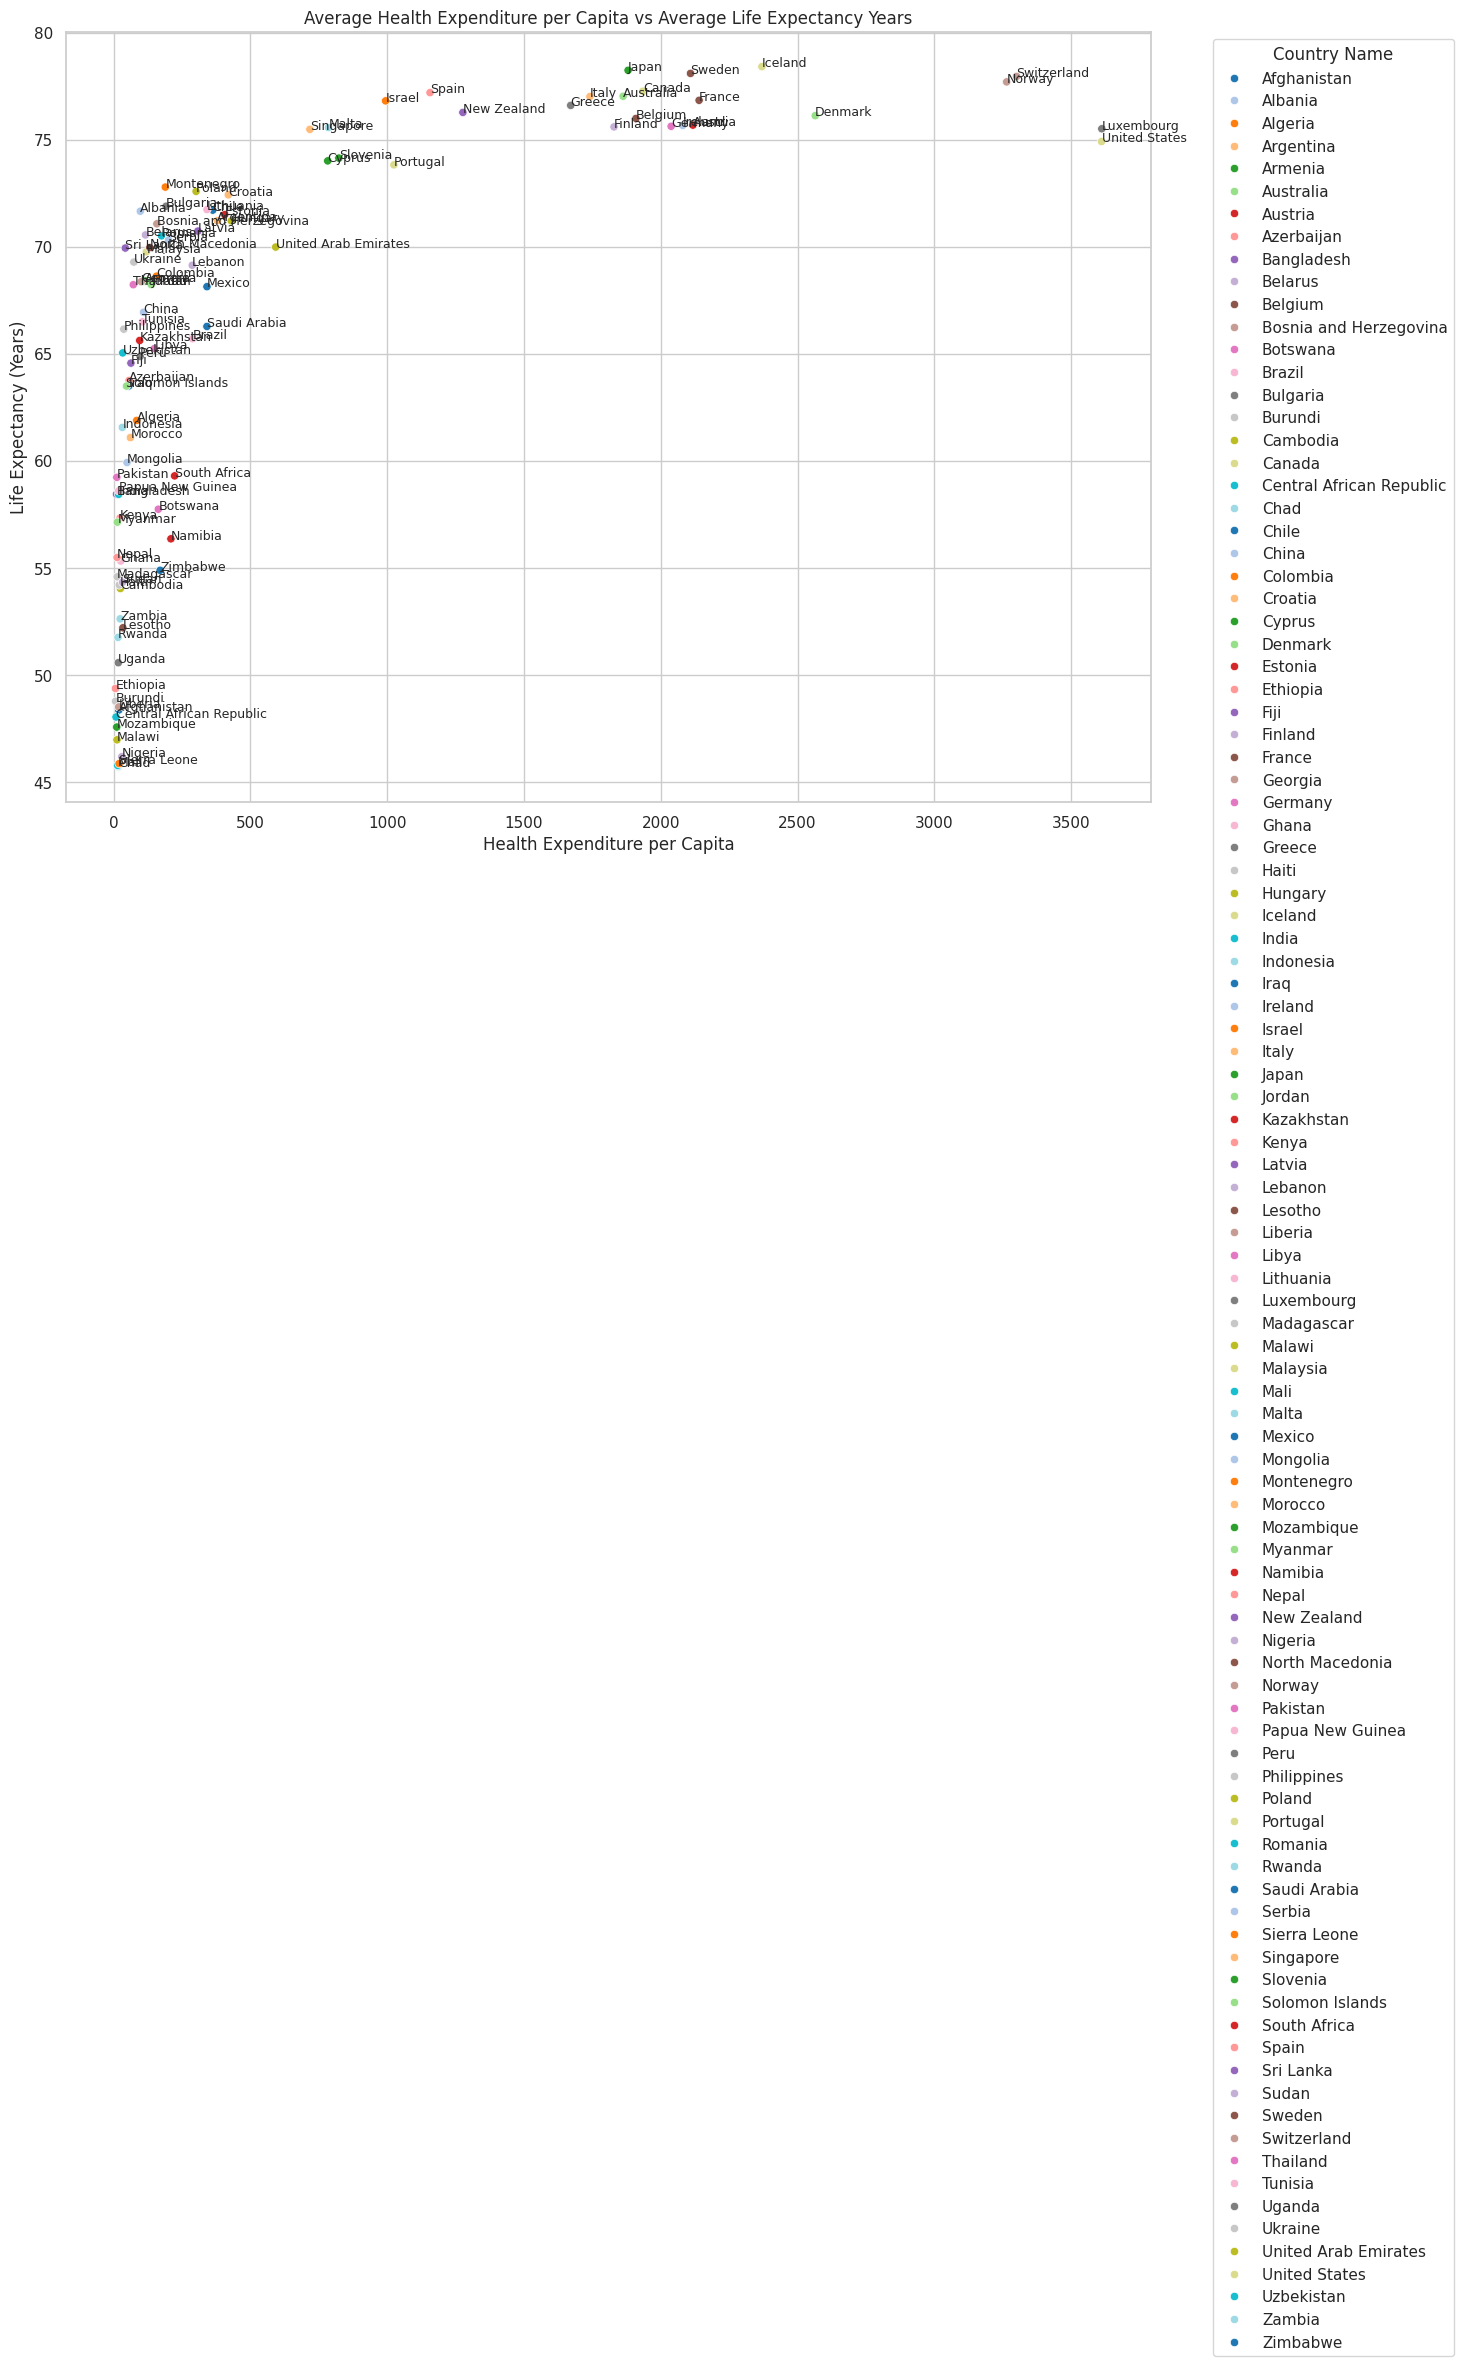

In [ ]:
_plot_average_health_expenditure_vs_outcome(df, 'HEALTH_EXPENDITURE_PER_CAPITA', 'LIFE_EXPECTANCY_YEARS')

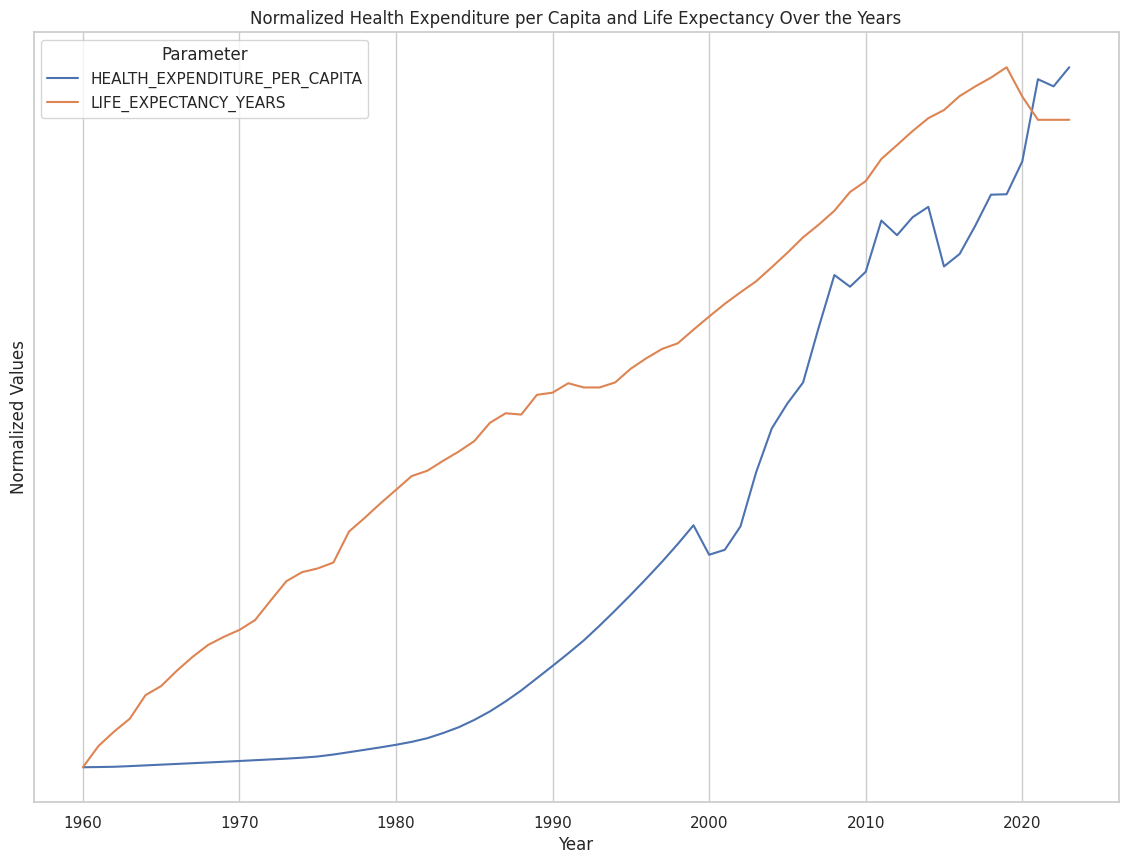

In [ ]:
_plot_normalized_expenditure_vs_life_expectancy_over_years(df, 'HEALTH_EXPENDITURE_PER_CAPITA', 'LIFE_EXPECTANCY_YEARS')

### Health Expenditures vs Economic Performance

On the first graph we are showing health expenditures correlate with the economic performance for each country. We are using GDP per Capita as the metric for economic performace. We can notice that there is a strong correlation between these two. On the graph we can see that if a country has a higher GDP per Capita, it will have higher Health Expenditures per Capita. We show this for each country averaged over the years.


On the second graph we are showing a graph where we can see the Health Expenditure per Capita and Economic Performance globally for all countries averaged over the years from 1960-2023. We can see that on average globally over the years as the average GDP per capita increases the health expenditures increase. The values were normalized to address the issue of different scales between economic performance and health expenditures.

In [ ]:
def _plot_average_health_expenditure_vs_economic_permofrance(df, expenditure_col, economic_permofrance):
    df[expenditure_col] = pd.to_numeric(df[expenditure_col], errors='coerce')
    df[economic_permofrance] = pd.to_numeric(df[economic_permofrance], errors='coerce')

    df_avg = df.groupby('Country Name')[[expenditure_col, economic_permofrance]].mean().reset_index()

    plt.figure(figsize=(14, 10))
    sns.scatterplot(x=expenditure_col, y=economic_permofrance, data=df_avg, hue='Country Name', palette='tab20')
    plt.title('Average Health Expenditure per Capita vs GDP per Capita')
    plt.xlabel('Health Expenditure per Capita')
    plt.ylabel('GDP per Capita')
    plt.legend(title='Country Name', bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.show()

In [ ]:
def _plot_normalized_expenditure_vs_economic_permofrance_over_years(df, expenditure_col, economic_permofrance):
    df[expenditure_col] = pd.to_numeric(df[expenditure_col], errors='coerce')
    df[economic_permofrance] = pd.to_numeric(df[economic_permofrance], errors='coerce')

    df_avg = df.groupby('Year')[[expenditure_col, economic_permofrance]].mean().reset_index()

    scaler = MinMaxScaler()
    df_avg[[expenditure_col, economic_permofrance]] = scaler.fit_transform(df_avg[[expenditure_col, economic_permofrance]])

    plt.figure(figsize=(14, 10))
    sns.lineplot(x='Year', y=expenditure_col, data=df_avg, label=expenditure_col)
    sns.lineplot(x='Year', y=economic_permofrance, data=df_avg, label=economic_permofrance)

    plt.title('Normalized Health Expenditure per Capita and GDP per Capita')
    plt.xlabel('Year')
    plt.yticks([])
    plt.ylabel('Normalized Values')
    plt.legend(title='Parameter')
    plt.grid(True)
    plt.show()

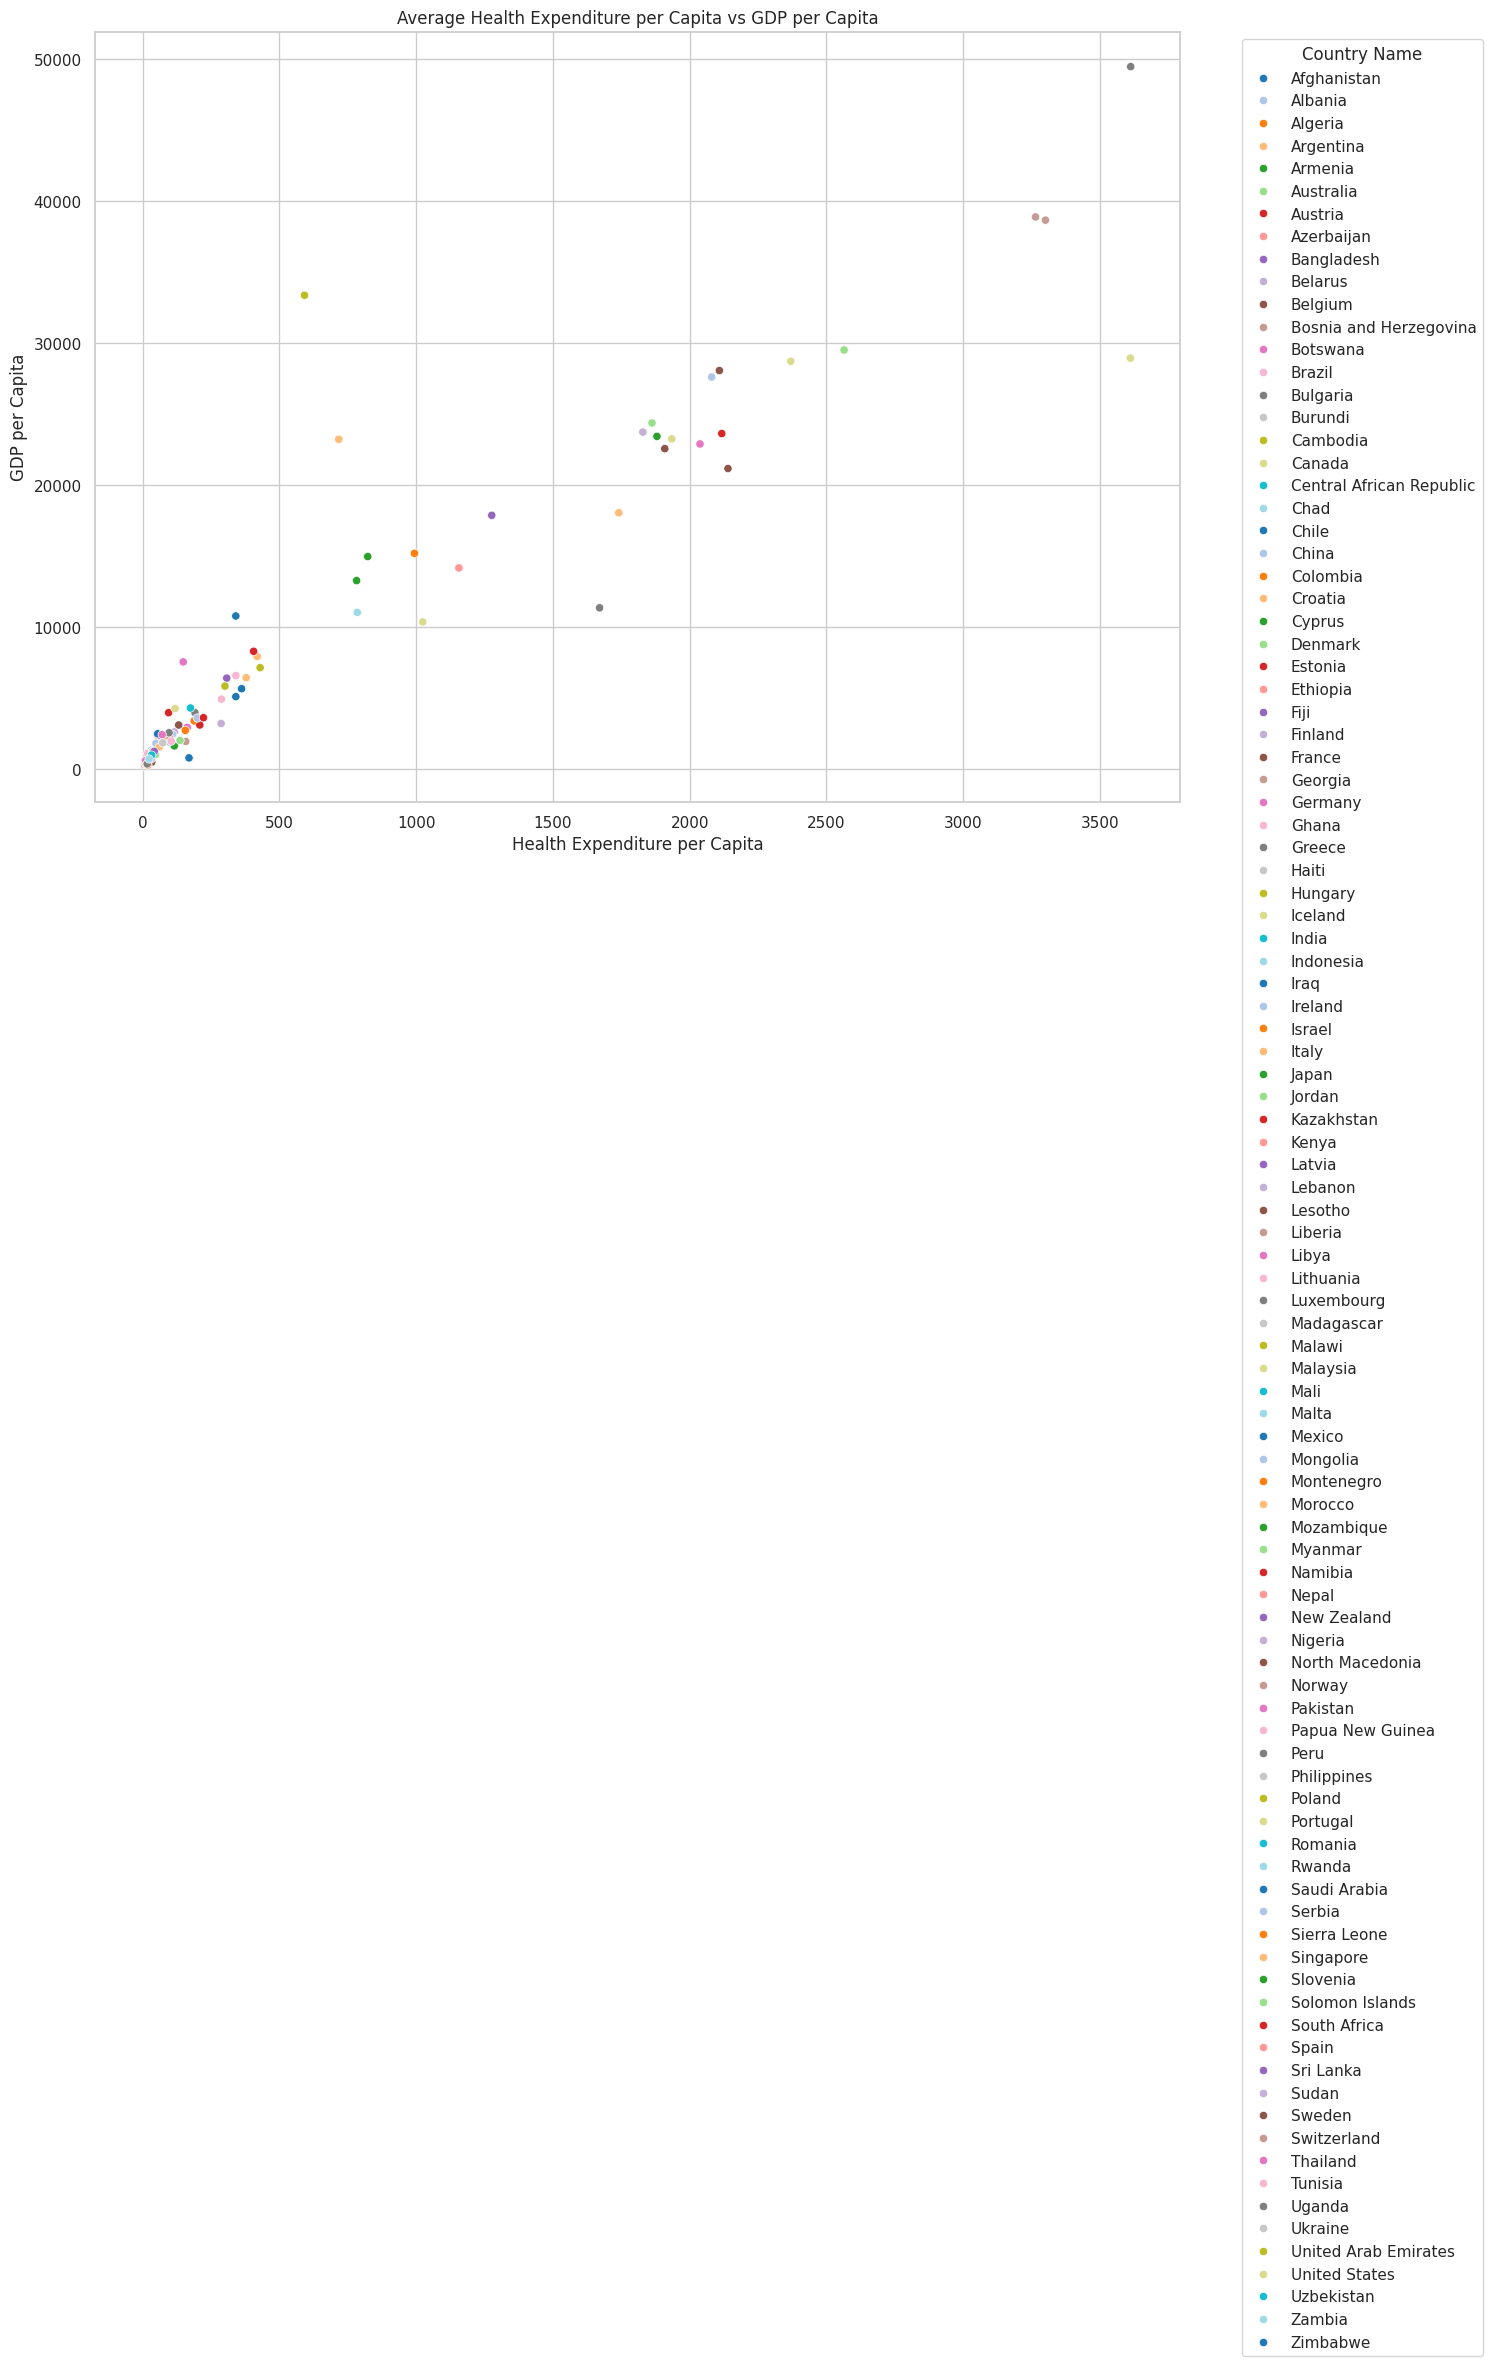

In [ ]:
_plot_average_health_expenditure_vs_economic_permofrance(df, 'HEALTH_EXPENDITURE_PER_CAPITA', 'GDP_PER_CAPITA')

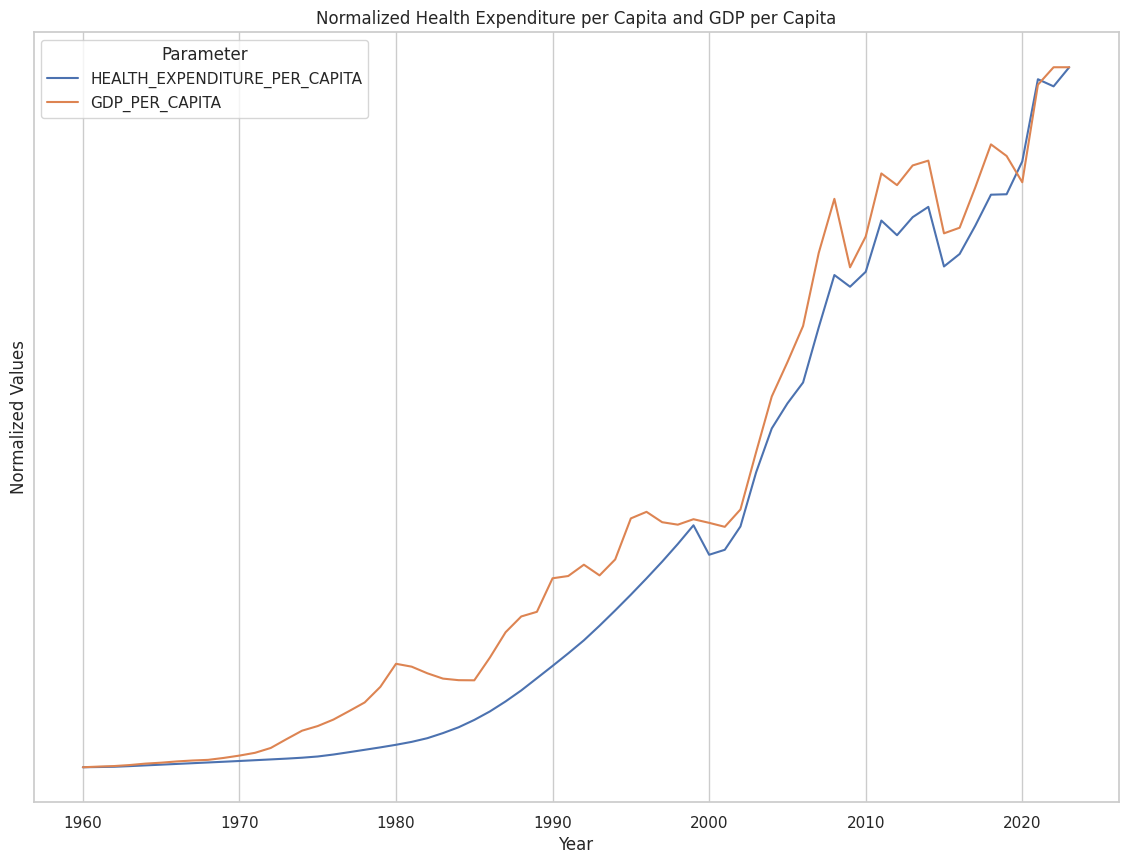

In [ ]:
_plot_normalized_expenditure_vs_economic_permofrance_over_years(df, 'HEALTH_EXPENDITURE_PER_CAPITA', 'GDP_PER_CAPITA')

## Findings

**Key Findings:**


1. We observed a generally positive correlation between health expenditure per capita and health outcomes, and with economic performance. Countries that invested more in health tended to have better health outcomes, demonstrating the importance of health investments in improving population health. Countries that have a better economic performance, tended to spend more in health expenditures.
2. The line plots showed that, on average, both health expenditures and life expectancy have increased over the years. This indicates that global health investments have been growing, contributing to better health outcomes. And that on average, both economic performance and health expenditures have increased over the years.
3. The analysis revealed variations among some countries. While some countries showed a strong positive relationship between health investments and health outcomes, as well as economic performance, others had weaker correlations, suggesting that factors other than health expenditure also play crucial roles in determining health outcomes. But mostly, there was a strong relationship between health investments and health outcomes, as well as economic performance.
4. The regression analysis showed that health expenditures and a countries GDP positively impact health outcomes.

**Correlations:**

* **Positive Correlation:** Health expenditures and life expectancy show a strong positive correlation, indicating that higher health spending is associated with longer life expectancy.
* **Positive Correlation:** Health expenditures and GDP per capita show a strong positive correlation, indicating that higher GDP is associated with higher health expenditures.
* **Negative Correlation:** Health expenditures and neonatal mortality rate are negatively correlated, suggesting that increased health spending reduces infant mortality.



## References

* [WHO Global Health Observatory](https://www.who.int/data/gho) - Provides data on health expenditures and outcomes.
* [IMF Data](https://data.imf.org) -  Offers data on economic performance metrics.
* [World Bank Data](https://data.worldbank.org/indicator) - Complements IMF data with additional economic indicators.


## Conclusion

This analysis highlights the significant relationship between public health expenditures and health outcomes, which in turn affect economic performance.

Our analysis underscores the critical role of public health expenditures in enhancing health outcomes across the globe. By investing in health, countries can achieve significant improvements in life expectancy and overall well-being of their populations. And improve their economic performance as a whole. However, the effectiveness of health investments varies by country, influenced by other socio-economic factors. Future research could dive deeper into these factors to provide a more nuanced understanding of how to optimize health investments for better outcomes.

Overall, this project highlights the importance of continued investment in public health and the need for tailored approaches that consider country-specific contexts to achieve the best health outcomes.

## Contributors

* **Nikola Dinevski**
* **Petar Atanasovski**